In [1]:
# Import necessary libraries
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
import torch.optim as optim
import pickle

# lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
import matplotlib.pyplot as plt

%matplotlib inline

(array([2482.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2473.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

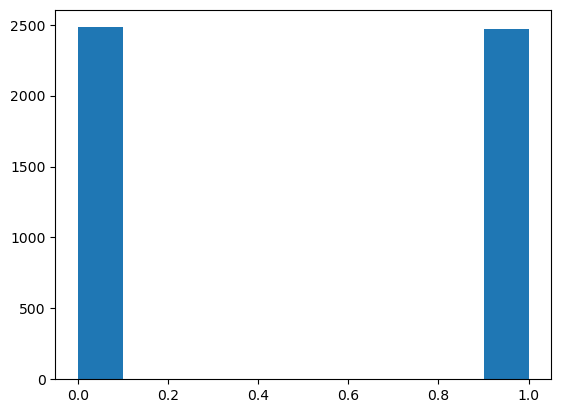

In [2]:
# Open the file in read mode
with open('sequences.pkl', 'rb') as file:
    # Load the list of tuples from the file
    sequences = pickle.load(file)
labels = [int(t[1]) for t in sequences]
plt.hist(labels)

In [3]:
train_seq, test_seq = train_test_split(sequences, random_state=420, test_size=0.2)
train_seq[2000]

(         TimeStamp       X_gaze      Y_gaze  Pupil radius        DVA
 4545910       4038   704.866667  459.866667        5167.0  20.521946
 4545911       4040   704.400000  459.666667        5166.0  20.534210
 4545912       4042   704.866667  459.400000        5166.0  20.526367
 4545913       4044   705.266667  459.333333        5164.0  20.518113
 4545914       4046   705.466667  460.666667        5164.0  20.501043
 ...            ...          ...         ...           ...        ...
 4546785       5788  1060.866667  512.000000        4796.0  12.280924
 4546786       5790  1061.400000  511.600000        4798.0  12.275276
 4546787       5792  1062.600000  512.066667        4801.0  12.244605
 4546788       5794  1063.266667  513.000000        4805.0  12.218695
 4546789       5796  1063.600000  513.266667        4805.0  12.208373
 
 [880 rows x 5 columns],
 1)

In [4]:
n_timesteps, n_features, n_outputs = trainX.shape[1], len(train_seq[0][0].columns), 2
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32
trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))

NameError: name 'trainX' is not defined

Dataset

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
class EyeTrackingDataModule(pl.LightningDataModule):

    def __init__(self, train_sequence, test_sequence, batch_size):
        super().__init__()
        self.train_sequence = train_sequence
        self.test_sequence = test_sequence
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_sequence = EyeTrackingDataset(self.train_sequence)
        self.test_sequence = EyeTrackingDataset(self.test_sequence)

    def train_dataloader(self):
        return DataLoader(self.train_sequence, batch_size=self.batch_size, shuffle=True, num_workers=16)

    def val_dataloader(self):
        return DataLoader(self.test_sequence, batch_size=self.batch_size, shuffle=False, num_workers=16)

    def test_dataloader(self):
        return DataLoader(self.test_sequence, batch_size=self.batch_size, shuffle=False, num_workers=16)

In [ ]:
N_EPOCHS = 250
BATCH_SIZE = 64 # ?

data_module = EyeTrackingDataModule(train_seq, test_seq, BATCH_SIZE)

Model

In [ ]:
class SequenceModel(nn.Module):

    def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
        super().__init__()

        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.75
        )

        self.classifier = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)

        out = hidden[-1]
        return self.classifier(out)

In [ ]:
class EyeTrackingPredictor(pl.LightningModule):

    def __init__(self, n_features:int, n_classes:int):
        super().__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = torchmetrics.functional.accuracy(predictions, labels, task="binary")
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}

    def validation_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = torchmetrics.functional.accuracy(predictions, labels, task="binary")

        self.log("validation_loss", loss, prog_bar=True, logger=True)
        self.log("validation_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}

    def test_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = torchmetrics.functional.accuracy(predictions, labels, task="binary")

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr = 0.0001)

In [ ]:
model = EyeTrackingPredictor(
    n_features=len(sequences[0][0].columns),
    n_classes=2
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="validation_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="EyeTracking")

trainer = pl.Trainer(logger=logger, callbacks=checkpoint_callback, max_epochs=N_EPOCHS, enable_progress_bar=True)

In [ ]:
trainer.fit(model, data_module)